In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, BatchNormalization, Input
import sklearn
from sklearn.model_selection import train_test_split

print(f' ------------- \n',
      f'Versions: \n',
      f'------------- \n'
      f' numpy=={np.__version__} \n'
      f' tensorflow=={tf.__version__} \n'
      f' sklearn=={sklearn.__version__} \n'
      f' keras=={keras.__version__} \n'
     )

 ------------- 
 Versions: 
 ------------- 
 numpy==1.22.1 
 tensorflow==2.11.1 
 sklearn==1.2.1 
 keras==2.11.0 



- ## Reference Values:

In [5]:
h_ref = 1e-2
rho_ref = 5e3
lambda_ref = 2.5e3**2*rho_ref
c_ref = np.sqrt(lambda_ref/rho_ref)

## Material Properties

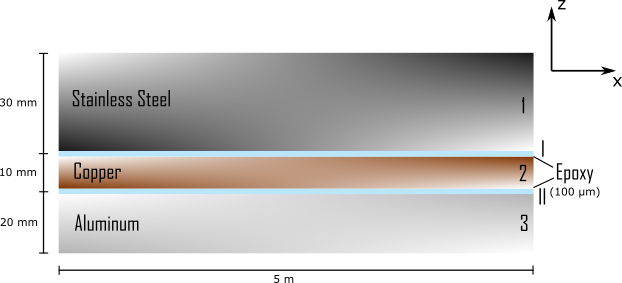

> Importing mode parameters:

In [6]:
interface_of_interest = 'aluminum-copper'
direction_of_interest = 'zz'

def load_mode_parameters():
    with open(f'./results/modes_parameters/kx_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        kx_mode = pickle.load(fp)
    with open(f'./results/modes_parameters/freq_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        freq_mode = 1000*pickle.load(fp)
    with open(f'./results/modes_parameters/deltaU_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        deltaU = pickle.load(fp)
    with open(f'./results/modes_parameters/u_1_spec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        u_1_spec = pickle.load(fp)
    with open(f'./results/modes_parameters/u_2_spec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        u_2_spec = pickle.load(fp)
    with open(f'./results/modes_parameters/x_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        x = pickle.load(fp)
    with open(f'./results/modes_parameters/kx_vec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        kx_vec = pickle.load(fp)
        
    return kx_mode, freq_mode, deltaU, u_1_spec, u_2_spec, x, kx_vec

kx_mode, freq_mode, deltaU, u_1_spec, u_2_spec, x, kx = load_mode_parameters()

nkx = len(kx)
omega = freq_mode*2*np.pi*h_ref/c_ref
x_dimensionless = x/h_ref
nx = len(x)

- ### Layer 1 (Aluminum):

In [7]:
rho_1 = 2700/rho_ref
vp_1 = 6320/c_ref
vs_1 = 3130/c_ref
mu_1 = vs_1**2*rho_1
lambda_1 = vp_1**2*rho_1-2*mu_1
h_1 = 2e-2/h_ref

- ### Layer 2 (Copper):

In [8]:
rho_2 = 8930/rho_ref
vp_2 = 4660/c_ref
vs_2 = 2660/c_ref
mu_2 = vs_2**2*rho_2
lambda_2 = vp_2**2*rho_2-2*mu_2
h_2 = 1e-2/h_ref

- ### Layer 3 (Stainless Steel):

In [9]:
rho_3 = 7900/rho_ref
vp_3 = 5790/c_ref
vs_3 = 3100/c_ref
mu_3 = vs_3**2*rho_3
lambda_3 = vp_3**2*rho_3-2*mu_3
h_3 = 3e-2/h_ref

- ### Interfaces:

> ##### Interface II (Layers 1-2)

In [10]:
h_interface_2 = 100e-6/h_ref
vp_interface_2 = 2150/c_ref
vs_interface_2 = 1030/c_ref
rho_interface_2 = 1200/rho_ref

> ##### Interface III (Layers 2-3)

In [11]:
h_interface_3 = 100e-6/h_ref
vp_interface_3 = 2150/c_ref
vs_interface_3 = 1030/c_ref
rho_interface_3 = 1200/rho_ref

> ##### Computing specular stiffness (QSA):

In [12]:
def computeSpecularStiffness(thickness, rho, P_speed, S_speed):
    mu = (S_speed**2)*rho
    lamb = (P_speed**2)*rho-2*mu
    s = 1/mu
    c = 2*mu+lamb
    K_specular = np.linalg.inv(thickness*np.array([[s, 0, 0], [0, s, 0], [0, 0, 1/c]]))
    return K_specular

- ## Generating damage profiles:

In [13]:
defect_dict = {'xx': 0, 'yy': 1, 'zz': 2}

def randomFieldDefect(
    x,
    correlation_length,
    stdev,
    number_of_samples,
    mean_random_field=0,
    field_type = 'gaussian'
):

    n_elements = len(x)
    if field_type == 'gaussian':
        covariance_field = lambda r, s :stdev ** 2 * np.exp(-1 * ((r - s) / correlation_length) ** 2)
    elif field_type == 'exponential':
        covariance_field = lambda r, s : stdev ** 2 * np.exp(-1 * abs(r - s) / correlation_length)
    else:
        return print('error - field type not found')
    covariance_matrix = np.zeros((n_elements, n_elements))
    for ii in range(0, n_elements):
        for jj in range(ii, n_elements):
            covariance_matrix[ii, jj] = covariance_field(x[ii], x[jj])
    covariance_matrix = (covariance_matrix + covariance_matrix.T) - np.diag(np.diag(covariance_matrix))
    xi = np.random.randn(n_elements, number_of_samples)
    muY = mean_random_field * np.ones((n_elements, number_of_samples))
    Ag, Ug = np.linalg.eig(covariance_matrix)
    Ag = np.diag(Ag)
    Vg = np.dot(Ug, np.real(np.sqrt(Ag, dtype = complex)))
    random_field = muY + np.dot(Vg, xi)
    random_field_transformed = np.tanh(np.exp(-random_field))
    for ii in range(0, number_of_samples):
        random_field_transformed[:, ii] = (random_field_transformed[:, ii] - max(random_field_transformed[:, ii]))
    # filter to avoid having defects at the edges:
    filter_center = (x[0] + x[-1])/2
    filter_sigma = x[-1]/24
    filter_offset = x[-1] - x[-1]/6.5*(x[-1] - x[0])
    field_filter = np.zeros(x.shape)
    
    random_field_filtered = np.zeros(random_field.shape)
    for ii in range(0, len(x)):
        field_filter[ii] = np.exp(- np.max([0, abs(x[ii] - filter_center) - filter_offset]) / (2 * filter_sigma ** 2))
    damage_field = np.zeros(random_field.shape)
    damage_field_transformed = np.zeros(random_field.shape)
    for ii in range(len(x)):
        damage_field_transformed[ii, :] = field_filter[ii] * random_field_transformed[ii, :] + 1
        random_field_filtered[ii, :] = field_filter[ii] * random_field[ii, :]
        
    return random_field, damage_field_transformed, covariance_matrix

def gaussianDefect(x, magnitude, mean = None, stdev = None):
    if mean is None:
        mean = (max(x) + min(x))/2
    if stdev is None:
        stdev = max(x)/100
    if stdev == 0:
        gaussian = np.zeros((len(x),)) + 1
        return gaussian

    gaussian = 1 - magnitude * np.exp(-((x - mean) / stdev) ** 2)
    return gaussian

def rectangularDefect(x, magnitude, x_min = None, x_max = None):
    if x_min is None:
        x_min = min(x)
    if x_max is None:
        x_max = max(x)
    rectangular = []
    for ii in x:
        if ii < x_min:
            rectangular.append(0)
        elif ii >= x_min and ii <= x_max:
            rectangular.append(magnitude)
        else:
            rectangular.append(0)
    rectangular = np.array(rectangular)
    rectangular = 1 - rectangular
                
    return rectangular

- ## Acoustic Tensors:

In [14]:
def computePropagationMatrices(kx, kp, kt, h_up, h_down):
    
    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)
    
    gamma_up = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_up,
        [np.exp(1j*kp_z*h_up),
         np.exp(1j*kt_z*h_up),
         np.exp(1j*kt_z*h_up)]
    )
    gamma_down = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_down,
        [np.exp(-1j*kp_z*h_down),
         np.exp(-1j*kt_z*h_down),
         np.exp(-1j*kt_z*h_down)]
    )

    A_up = np.array(
        [[kx/kp, -kt_z/kt, 0],
         [0, 0, 1],
         [kp_z/kp, kx/kt, 0]]
    )
    A_down = np.array(
        [[kx/kp, kt_z/kt, 0],
         [0, 0, 1],
         [-kp_z/kp, kx/kt, 0]]
    )

    M_up = np.dot(np.dot(A_up, gamma_up), np.linalg.inv(A_up))
    M_down = np.dot(np.dot(A_down, gamma_down), np.linalg.inv(A_down))

    return M_up, M_down


########################################################################################


def computeImpedances(omega, kx, kp, kt, lambda_, mu):

    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)

    A_aux_up = np.array([[kx, kp_z], [kt_z, -kx]], dtype=complex)
    A_aux_down = np.array([[-kx, kp_z], [kt_z, kx]], dtype=complex)

    C1_up = np.array(
        [[-2*mu*kp_z*kx/omega], [(mu/omega)*(kx**2-kt_z**2)]],
        dtype = complex
    )
    C2_up = np.array(
        [[-(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )
    C1_down = np.array(
        [[-2*mu*kp_z*kx/omega], [-(mu/omega)*(kx**2-kt_z**2)]],
        dtype=complex
    )
    C2_down = np.array(
        [[(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )

    z_11_up_z_13_up = np.dot(np.linalg.inv(A_aux_up), C1_up)
    z_11_up = z_11_up_z_13_up[0]
    z_13_up = z_11_up_z_13_up[1]
    z_12_up = 0
    z_21_up = 0
    z_22_up = -mu*kt_z/omega
    z_23_up = 0
    z_32_up = 0
    z_31_up_z_33_up = np.dot(np.linalg.inv(A_aux_up), C2_up)
    z_31_up = z_31_up_z_33_up[0]
    z_33_up = z_31_up_z_33_up[1]

    z_11_down_z_13_down = np.dot(np.linalg.inv(A_aux_down), C1_down)
    z_11_down = z_11_down_z_13_down[0]
    z_13_down = z_11_down_z_13_down[1]
    z_12_down = 0
    z_21_down = 0
    z_22_down = mu*kt_z/omega
    z_23_down = 0
    z_32_down = 0
    z_31_down_z_33_down = np.dot(np.linalg.inv(A_aux_down), C2_down)
    z_31_down = z_31_down_z_33_down[0]
    z_33_down = z_31_down_z_33_down[1]

    Z_up = np.array(
        [[z_11_up, z_12_up, z_13_up],
         [z_21_up, z_22_up, z_23_up],
         [z_31_up, z_32_up, z_33_up]],
        dtype=complex
    )

    Z_down = np.array(
        [[z_11_down, z_12_down, z_13_down],
         [z_21_down, z_22_down, z_23_down],
         [z_31_down, z_32_down, z_33_down]],
        dtype=complex
    )

    return Z_up, Z_down

- ## Damage Sample:

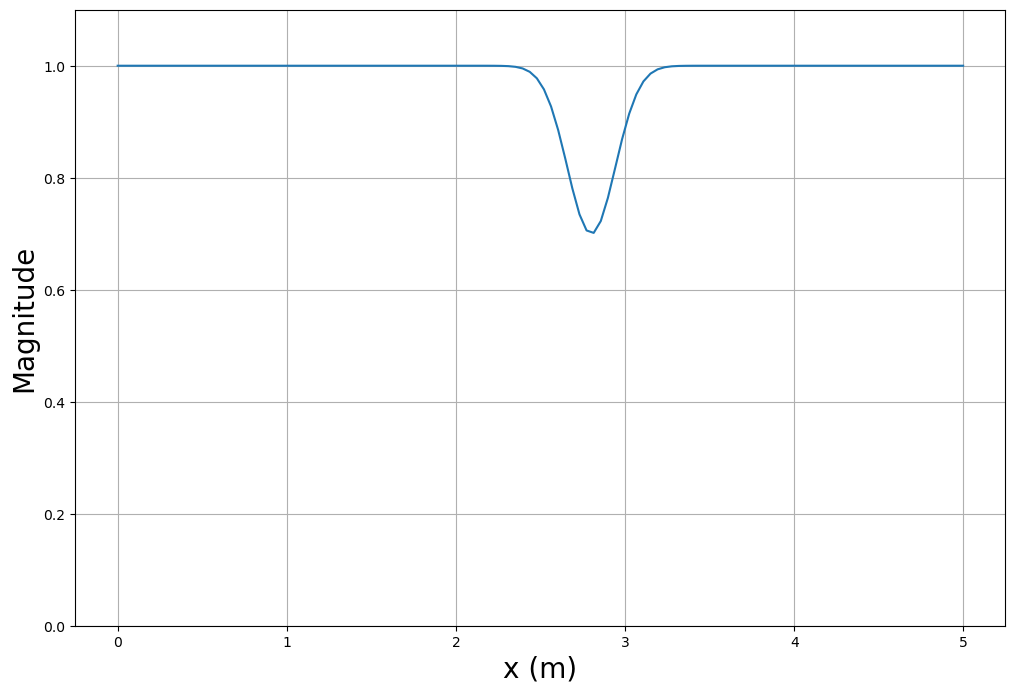

In [15]:
damage_1 = rectangularDefect(x, magnitude=0, x_min = 1.5, x_max = 1.7)#magnitude=0.6, x_min=1.5, x_max=1.7
damage_2 = gaussianDefect(x, magnitude=0.3, mean = 2.8, stdev = 0.2)#magnitude=0.3
damage = damage_1 + damage_2 - 1
#random_field, damage, cov_matrix = randomFieldDefect(
#            x,
#            correlation_length=0.2,
#            stdev=0.8,
#            number_of_samples=1,
#            mean_random_field=0,
#            field_type = 'gaussian'
#        )

damage = damage.reshape((120,))

plt.figure(figsize=(12, 8))
plt.plot(x, damage)
plt.ylim([0, 1.1])
plt.grid()
plt.ylabel('Magnitude', size=20)
plt.xlabel('x (m)', size=20)
plt.show()

#plt.figure(figsize=(12, 8))
#plt.plot(x, random_field)
#plt.ylim()
#plt.grid()
#plt.ylabel('Magnitude', size=20)
#plt.xlabel('x (m)', size=20)
#plt.show()

In [16]:
with open(f'./results/modes_parameters/x_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
    x_space = pickle.load(fp)

def transform_field(gaussian_random_field, x_space, reduced=False):
    if len(gaussian_random_field.shape) == 2:
        gaussian_random_field = gaussian_random_field.reshape(-1)
    field_transformed = np.tanh(np.exp(-gaussian_random_field))
    field_transformed = (field_transformed - max(field_transformed))
    if reduced:
        x_space = model_reducing(x_space)
    filter_center = (x_space[0] + x_space[-1])/2
    filter_sigma = x_space[-1]/24
    filter_offset = x_space[-1] - x_space[-1]/6.5*(x_space[-1] - x_space[0])
    field_filter = np.zeros(x_space.shape)
    for ii in range(0, len(x_space)):
        field_filter[ii] = np.exp(- np.max([0, abs(x_space[ii] - filter_center) - filter_offset]) / (2 * filter_sigma ** 2))
    damage_field = field_filter * field_transformed + 1
    return damage_field

- ## Solving Direct Problem

In [17]:
interfaces_dict = {
    'aluminum-copper':0,
    'copper-stainless steel':1 
}

In [18]:
def computeScatteredStiffness(Kspec_2, Kspec_3):
    Kspec = [Kspec_2, Kspec_3]
    Kscat_2 = np.zeros((3, 3, nx))
    Kscat_3 = np.zeros((3, 3, nx))
    Kscat = [Kscat_2, Kscat_3]
    Kscat[interfaces_dict[interface_of_interest]][
        defect_dict[direction_of_interest],
        defect_dict[direction_of_interest],
        :
    ] = Kspec[interfaces_dict[interface_of_interest]][
        defect_dict[direction_of_interest],
        defect_dict[direction_of_interest]
    ]*damage - Kspec[interfaces_dict[interface_of_interest]][
        defect_dict[direction_of_interest],
        defect_dict[direction_of_interest]
    ]
    return Kscat[0], Kscat[1]

In [19]:
def solveAcousticScattering(damage, Kspec_2, Kspec_3):
    # Layer 1:

    Z_up_1 = np.zeros((3, 3, nkx), dtype = complex)
    Z_down_1 = np.zeros((3, 3, nkx), dtype = complex)
    M_up_1 = np.zeros((3, 3, nkx), dtype = complex)
    M_down_1 = np.zeros((3, 3, nkx), dtype = complex)
    kp_1 = omega/vp_1
    kt_1 = omega/vs_1

    # Layer 2:

    Z_up_2 = np.zeros((3, 3, nkx), dtype = complex)
    Z_down_2 = np.zeros((3, 3, nkx), dtype = complex)
    M_up_2 = np.zeros((3, 3, nkx), dtype = complex)
    M_down_2 = np.zeros((3, 3, nkx), dtype = complex)
    kp_2 = omega/vp_2
    kt_2 = omega/vs_2

    # Layer 3:

    Z_up_3 = np.zeros((3, 3, nkx), dtype = complex)
    Z_down_3 = np.zeros((3, 3, nkx), dtype = complex)
    M_up_3 = np.zeros((3, 3, nkx), dtype = complex)
    M_down_3 = np.zeros((3, 3, nkx), dtype = complex)
    kp_3 = omega/vp_3
    kt_3 = omega/vs_3
    
    if model_error:
        h_1

    for ii in range(nkx):

        Z_up_1[:, :, ii], Z_down_1[:, :, ii] = computeImpedances(omega, kx[ii], kp_1, kt_1, lambda_1, mu_1)
        M_up_1[:, :, ii], M_down_1[:, :, ii] = computePropagationMatrices(kx[ii], kp_1, kt_1, -h_1, -h_1)

        Z_up_2[:, :, ii], Z_down_2[:, :, ii] = computeImpedances(omega, kx[ii], kp_2, kt_2, lambda_2, mu_2)
        M_up_2[:, :, ii], M_down_2[:, :, ii] = computePropagationMatrices(kx[ii], kp_2, kt_2, -h_2, -h_2)

        Z_up_3[:, :, ii], Z_down_3[:, :, ii] = computeImpedances(omega, kx[ii], kp_3, kt_3, lambda_3, mu_3)
        M_up_3[:, :, ii], M_down_3[:, :, ii] = computePropagationMatrices(kx[ii], kp_3, kt_3, -h_3, -h_3)

    interfaces_dict = {
        'aluminum-copper':0,
        'copper-stainless steel':1 
    }

    deltaU_list = [np.zeros(deltaU.shape), np.zeros(deltaU.shape)]
    deltaU_list[interfaces_dict[interface_of_interest]] = deltaU
    deltaU_2 = deltaU_list[0]
    deltaU_3 = deltaU_list[1]

    Kscat_2, Kscat_3 = computeScatteredStiffness(Kspec_2, Kspec_3)

    p0_guess_fft = np.zeros((1, 4 * nkx), dtype = complex)
    u_guess_fft = np.zeros((3, nkx), dtype = complex)
    count = 0

    # assembling u1 at the top of the plate:
    for ii in range(0, len(p0_guess_fft[0,:]), 4):
        u_guess_fft[0, count] = p0_guess_fft[0, ii] + p0_guess_fft[0, ii + 1] * 1j
        u_guess_fft[1, count] = 0
        u_guess_fft[2, count] = p0_guess_fft[0, ii + 2] + p0_guess_fft[0, ii + 3] * 1j
        count += 1
    u_up_top_3_fft = u_guess_fft

    u_down_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        u_down_top_3_fft[:, ii] = -np.dot(np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]), u_up_top_3_fft[:, ii])

    u_down_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_up_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        u_up_bottom_3_fft[:, ii] = np.dot(M_up_3[: ,:, ii], u_up_top_3_fft[:, ii])
        u_down_bottom_3_fft[:, ii] = np.dot(M_down_3[: ,:, ii], u_down_top_3_fft[:, ii])

    u_bottom_3_fft = u_up_bottom_3_fft + u_down_bottom_3_fft
    t_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        t_bottom_3_fft[:, ii] = -1j*omega*(
            np.dot(Z_up_3[:, :, ii], u_up_bottom_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_bottom_3_fft[:, ii])
        )

    u_bottom_3 = np.array(
        [np.fft.ifft(np.fft.ifftshift(u_bottom_3_fft[dim, :])) for dim in range(u_bottom_3_fft.shape[0])]
    )
    t_bottom_3 = np.array(
        [np.fft.ifft(np.fft.ifftshift(t_bottom_3_fft[dim, :])) for dim in range(t_bottom_3_fft.shape[0])]
    )

    K_3 = np.zeros((3, 3, nx))
    for ii in range(K_3.shape[0]):
        K_3[ii, ii, :] = Kspec_3[ii, ii] + Kscat_3[ii, ii, :]
    u_top_2 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        u_top_2[:, ii] = np.dot(
            np.linalg.inv(K_3[:, :, ii]),
            (np.dot(Kscat_3[:, :, ii], deltaU_3[:, ii]) - t_bottom_3[:, ii])
        ) + u_bottom_3[:, ii]

    u_top_2_fft = np.array(
        [np.fft.fftshift(np.fft.fft(u_top_2[dim, :])) for dim in range(u_top_2.shape[0])], dtype = complex
    )

    u_up_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_down_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        u_up_top_2_fft[:, ii] = -np.dot(
            np.linalg.inv(Z_up_2[:, :, ii]-Z_down_2[:, :, ii]),
            (t_bottom_3_fft[:, ii]/(1j*omega)-np.dot(Z_down_2[:, :, ii], u_top_2_fft[:, ii]))

        )
        u_down_top_2_fft[:, ii] = u_top_2_fft[:, ii] - u_up_top_2_fft[:, ii]

    u_down_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_up_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        u_up_bottom_2_fft[:, ii] = np.dot(M_up_2[: ,:, ii], u_up_top_2_fft[:, ii])
        u_down_bottom_2_fft[:, ii] = np.dot(M_down_2[: ,:, ii], u_down_top_2_fft[:, ii])

    u_bottom_2_fft = u_up_bottom_2_fft + u_down_bottom_2_fft
    t_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        t_bottom_2_fft[:, ii] = -1j*omega*(
            np.dot(Z_up_2[:, :, ii], u_up_bottom_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_bottom_2_fft[:, ii])
        )

    u_bottom_2 = np.array(
        [np.fft.ifft(np.fft.ifftshift(u_bottom_2_fft[dim, :])) for dim in range(u_bottom_2_fft.shape[0])]
    )
    t_bottom_2 = np.array(
        [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])]
    )

    K_2 = np.zeros((3, 3, nx))
    for ii in range(K_3.shape[0]):
        K_2[ii, ii, :] = Kspec_2[ii, ii] + Kscat_2[ii, ii, :]
    u_top_1 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        u_top_1[:, ii] = np.dot(
            np.linalg.inv(K_2[:, :, ii]),
            (np.dot(Kscat_2[:, :, ii], deltaU_2[:, ii]) - t_bottom_2[:, ii])
        ) + u_bottom_2[:, ii]

    u_top_1_fft = np.array(
        [np.fft.fftshift(np.fft.fft(u_top_1[dim, :])) for dim in range(u_top_1.shape[0])], dtype = complex
    )

    u_up_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_down_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        u_up_top_1_fft[:, ii] = -np.dot(
            np.linalg.inv(Z_up_1[:, :, ii]-Z_down_1[:, :, ii]),
            (t_bottom_2_fft[:, ii]/(1j*omega)-np.dot(Z_down_1[:, :, ii], u_top_1_fft[:, ii]))

        )
        u_down_top_1_fft[:, ii] = u_top_1_fft[:, ii] - u_up_top_1_fft[:, ii]

    u_down_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    u_up_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
    for ii in range(nkx):
        u_up_bottom_1_fft[:, ii] = np.dot(M_up_1[: ,:, ii], u_up_top_1_fft[:, ii])
        u_down_bottom_1_fft[:, ii] = np.dot(M_down_1[: ,:, ii], u_down_top_1_fft[:, ii])

    t_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

    for ii in range(nkx):
        t_bottom_1_fft[:, ii] = -1j*omega*(
            np.dot(Z_up_1[:, :, ii], u_up_bottom_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_bottom_1_fft[:, ii])
        )

    residual_vector = np.zeros((4*nkx, 1), dtype = complex)
    residual_aux1 = t_bottom_1_fft[0, :]
    residual_aux3 = t_bottom_1_fft[2, :]
    count = 0

    for ii in range(0, nkx):

        residual_vector[count, 0] = np.real(residual_aux1[ii])
        residual_vector[count+1, 0] = np.real(residual_aux3[ii])
        residual_vector[count+2, 0] = np.imag(residual_aux1[ii])
        residual_vector[count+3, 0] = np.imag(residual_aux3[ii])
        count += 4

    cost_function_0 = np.dot(residual_vector.T, residual_vector)


    jacobian_matrix = np.zeros((4*nkx, 4*nkx), dtype=complex)
    epsilon = 1.0

    for kk in range(0, 4*nkx):

        # Step 1

        p_fft = np.zeros((1, 4*nkx), dtype=complex)
        p_fft[0, kk] = p_fft[0, kk]+epsilon
        u_iter_fft = np.zeros((3, nkx), dtype=complex)
        count = 0
        for ii in range(0, len(p0_guess_fft[0,:]), 4):
            u_iter_fft[0, count] = p_fft[0, ii]+p_fft[0, ii+1]*1j
            u_iter_fft[1, count] = 0
            u_iter_fft[2, count] = p_fft[0, ii+2]+p_fft[0, ii+3]*1j
            count += 1
        u_up_top_3_fft = u_iter_fft

        # Step 2

        u_down_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_down_top_3_fft[:, ii] = -np.dot(np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]), u_up_top_3_fft[:, ii])

        # Step 3

        u_down_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_3_fft[:, ii] = np.dot(M_up_3[: ,:, ii], u_up_top_3_fft[:, ii])
            u_down_bottom_3_fft[:, ii] = np.dot(M_down_3[: ,:, ii], u_down_top_3_fft[:, ii])

        # Step 4

        u_bottom_3_fft = u_up_bottom_3_fft + u_down_bottom_3_fft
        t_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            t_bottom_3_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_3[:, :, ii], u_up_bottom_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_bottom_3_fft[:, ii])
            )

        u_bottom_3 = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_bottom_3_fft[dim, :])) for dim in range(u_bottom_3_fft.shape[0])]
        )
        t_bottom_3 = np.array(
            [np.fft.ifft(np.fft.ifftshift(t_bottom_3_fft[dim, :])) for dim in range(t_bottom_3_fft.shape[0])]
        )

        # Step 5

        K_3 = np.zeros((3, 3, nx))
        for ii in range(K_3.shape[0]):
            K_3[ii, ii, :] = Kspec_3[ii, ii] + Kscat_3[ii, ii, :]
        u_top_2 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_top_2[:, ii] = np.dot(
                np.linalg.inv(K_3[:, :, ii]),
                (np.dot(Kscat_3[:, :, ii], deltaU_3[:, ii]) - t_bottom_3[:, ii])
            ) + u_bottom_3[:, ii]

        u_top_2_fft = np.array(
            [np.fft.fftshift(np.fft.fft(u_top_2[dim, :])) for dim in range(u_top_2.shape[0])], dtype = complex
        )

        # Step 6

        u_up_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_down_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_up_top_2_fft[:, ii] = -np.dot(
                np.linalg.inv(Z_up_2[:, :, ii]-Z_down_2[:, :, ii]),
                (t_bottom_3_fft[:, ii]/(1j*omega)-np.dot(Z_down_2[:, :, ii], u_top_2_fft[:, ii]))

            )
            u_down_top_2_fft[:, ii] = u_top_2_fft[:, ii] - u_up_top_2_fft[:, ii]

        # Step 7

        u_down_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_2_fft[:, ii] = np.dot(M_up_2[: ,:, ii], u_up_top_2_fft[:, ii])
            u_down_bottom_2_fft[:, ii] = np.dot(M_down_2[: ,:, ii], u_down_top_2_fft[:, ii])

        u_bottom_2_fft = u_up_bottom_2_fft + u_down_bottom_2_fft
        t_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            t_bottom_2_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_2[:, :, ii], u_up_bottom_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_bottom_2_fft[:, ii])
            )

        u_bottom_2 = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_bottom_2_fft[dim, :])) for dim in range(u_bottom_2_fft.shape[0])]
        )
        t_bottom_2 = np.array(
            [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])]
        )

        K_2 = np.zeros((3, 3, nx))
        for ii in range(K_3.shape[0]):
            K_2[ii, ii, :] = Kspec_2[ii, ii] + Kscat_2[ii, ii, :]
        u_top_1 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_top_1[:, ii] = np.dot(
                np.linalg.inv(K_2[:, :, ii]),
                (np.dot(Kscat_2[:, :, ii], deltaU_2[:, ii]) - t_bottom_2[:, ii])
            ) + u_bottom_2[:, ii]

        u_top_1_fft = np.array(
            [np.fft.fftshift(np.fft.fft(u_top_1[dim, :])) for dim in range(u_top_1.shape[0])], dtype = complex
        )

        u_up_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_down_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_up_top_1_fft[:, ii] = -np.dot(
                np.linalg.inv(Z_up_1[:, :, ii]-Z_down_1[:, :, ii]),
                (t_bottom_2_fft[:, ii]/(1j*omega)-np.dot(Z_down_1[:, :, ii], u_top_1_fft[:, ii]))

            )
            u_down_top_1_fft[:, ii] = u_top_1_fft[:, ii] - u_up_top_1_fft[:, ii]

        u_down_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_1_fft[:, ii] = np.dot(M_up_1[: ,:, ii], u_up_top_1_fft[:, ii])
            u_down_bottom_1_fft[:, ii] = np.dot(M_down_1[: ,:, ii], u_down_top_1_fft[:, ii])

        # Step 8

        t_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            t_bottom_1_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_1[:, :, ii], u_up_bottom_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_bottom_1_fft[:, ii])
            )

        # Step 9

        residual_vector_jacobian = np.zeros((4*nkx, 1), dtype = complex)
        residual_aux1_jacobian = t_bottom_1_fft[0, :]
        residual_aux3_jacobian = t_bottom_1_fft[2, :]
        count = 0

        for ii in range(0, nkx):

            residual_vector_jacobian[count, 0] = np.real(residual_aux1_jacobian[ii])
            residual_vector_jacobian[count+1, 0] = np.real(residual_aux3_jacobian[ii])
            residual_vector_jacobian[count+2, 0] = np.imag(residual_aux1_jacobian[ii])
            residual_vector_jacobian[count+3, 0] = np.imag(residual_aux3_jacobian[ii])
            count += 4

        # Assembling the Jacobian Matrix

        jacobian_matrix[:, kk] = (residual_vector_jacobian[:, 0] - residual_vector[:, 0])/epsilon

    solution_vector = p0_guess_fft.T - np.dot(np.linalg.inv(jacobian_matrix), residual_vector)
    u_up_solution_fft = np.zeros((3, nkx), dtype=complex)
    u_up_solution = np.zeros((3, nkx), dtype=complex)
    count = 0

    for ii in range(0, len(solution_vector), 4):
        u_up_solution_fft[0, count] = solution_vector[ii, 0] + solution_vector[ii+1, 0]*1j
        u_up_solution_fft[2, count] = solution_vector[ii+2, 0] + solution_vector[ii+3, 0]*1j
        count += 1

    u_down_solution_fft = np.zeros((3, nkx), dtype=complex)
    u_down_solution = np.zeros((3, nkx), dtype=complex)
    for ii in range(nkx):
        u_down_solution_fft[:, ii] = -np.dot(
            np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]),
            u_up_solution_fft[:, ii]
        )

    u_solution_fft = u_up_solution_fft + u_down_solution_fft

    u_up_solution = np.array(
        [np.fft.ifft(np.fft.ifftshift(u_up_solution_fft[dim, :])) for dim in range(u_up_solution_fft.shape[0])]
    )
    u_down_solution = np.array(
        [np.fft.ifft(np.fft.ifftshift(u_down_solution_fft[dim, :])) for dim in range(u_down_solution_fft.shape[0])]
    )
    u_solution = np.array(
        [np.fft.ifft(np.fft.ifftshift(u_solution_fft[dim, :])) for dim in range(u_solution_fft.shape[0])]
    )
    
    return u_solution

In [20]:
def compute_scattered_field(model_error=None):

    if model_error:

        Kspec_2 = computeSpecularStiffness(
            h_interface_2-model_error*h_interface_2,
            rho_interface_2,
            vp_interface_2,
            vs_interface_2
        )

        Kspec_3 = computeSpecularStiffness(
            h_interface_3-model_error*h_interface_3,
            rho_interface_3,
            vp_interface_3,
            vs_interface_3
        )

        u_scattered_minus = solveAcousticScattering(damage, Kspec_2, Kspec_3)

        Kspec_2 = computeSpecularStiffness(
            h_interface_2+model_error*h_interface_2,
            rho_interface_2,
            vp_interface_2,
            vs_interface_2
        )

        Kspec_3 = computeSpecularStiffness(
            h_interface_3+model_error*h_interface_3,
            rho_interface_3,
            vp_interface_3,
            vs_interface_3
        )

        u_scattered_plus = solveAcousticScattering(damage, Kspec_2, Kspec_3)
            
        return u_scattered_minus, u_scattered_plus

    else:

        Kspec_2 = computeSpecularStiffness(h_interface_2, rho_interface_2, vp_interface_2, vs_interface_2)
        Kspec_3 = computeSpecularStiffness(h_interface_3, rho_interface_3, vp_interface_3, vs_interface_3)
        u_scattered = solveAcousticScattering(damage, Kspec_2, Kspec_3)
            
        return u_scattered

- ## Loading Deep Learning Model:

In [21]:
reduced_model_points = None
direction = 'zz'

def load_model(model_name):
    model = pickle.load(open(f'./results/models/{model_name}', 'rb'))
    return model

if reduced_model_points:
    model = load_model(model_name=f'{direction}_{reduced_model_points}')
else: 
    model = load_model(model_name=f'{direction}_full')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-08-02 10:45:54         5290
metadata.json                                  2023-08-02 10:45:54           64
variables.h5                                   2023-08-02 10:45:54       463880
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_2
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\input_layer
..

- ## Predict:

In [25]:
interface_of_interest = 'aluminum-copper'
direction_of_interest = 'zz'

def importData(interface_of_interest, direction_of_interest):

    random_fields_path = f'./data/{interface_of_interest}_{direction_of_interest}/random_fields/'
    lst = os.listdir(random_fields_path)
    random_field_files = [os.path.join(random_fields_path,el) for el in lst]
    random_field_list = []
    for file in random_field_files:
        with open(file, 'rb') as fp:
            random_field_list.append(pickle.load(fp))
    random_field_list = np.array(random_field_list)
    random_field_list = random_field_list.reshape(random_field_list.shape[:2])


    damages_path = f'./data/{interface_of_interest}_{direction_of_interest}/damages/'
    lst = os.listdir(damages_path)
    damage_files = [os.path.join(damages_path, el) for el in lst]
    damage_list = []
    for file in damage_files:
        with open(file, 'rb') as fp:
            damage_list.append(pickle.load(fp))
    damage_list = np.array(damage_list)
    damage_list = damage_list.reshape(damage_list.shape[:2])

    scattered_fields_path = f'./data/{interface_of_interest}_{direction_of_interest}/scattered_fields/'
    lst = os.listdir(scattered_fields_path)
    scattered_field_files = [os.path.join(scattered_fields_path, el) for el in lst]
    scattered_field_x_list = []
    scattered_field_z_list = []
    for file in scattered_field_files:
        with open(file, 'rb') as fp:
            scattered_field_sample = pickle.load(fp)
            scattered_field_x_list.append(scattered_field_sample[0, :])
            scattered_field_z_list.append(scattered_field_sample[2, :])
    scattered_field_x_list = np.array(scattered_field_x_list)
    scattered_field_x_list = scattered_field_x_list.reshape(scattered_field_x_list.shape[:2])
    scattered_field_z_list = np.array(scattered_field_z_list)
    scattered_field_z_list = scattered_field_z_list.reshape(scattered_field_z_list.shape[:2])

    specular_field_file = f'./data/{interface_of_interest}_{direction_of_interest}/u_spec'
    cov_matrix_file = f'./data/{interface_of_interest}_{direction_of_interest}/cov_matrix'

    with open(specular_field_file, 'rb') as fp:
        specular_field = pickle.load(fp)
    specular_field_x = specular_field[0, :]
    specular_field_z = specular_field[2, :]

    with open(cov_matrix_file, 'rb') as fp:
        cov_matrix = pickle.load(fp)
        
    with open(f'./results/modes_parameters/x_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        x = pickle.load(fp)
        
    return (
        random_field_list,
        damage_list,
        scattered_field_x_list,
        scattered_field_z_list,
        specular_field_x,
        specular_field_z,
        cov_matrix,
        x
    )

# Adding noise to the scattered field input
def noise(data, level):
    noise = np.random.uniform(low=0.0,high=level*np.max(data),size=data.shape[0])
    noisy_data = data + noise
    return noisy_data

# Defining the reduced model points
def model_reducing(data):
    idx = np.round(np.linspace(0, data.shape[0] - 1, reduced_model_points)).astype(int)
    reduced_data = data[idx]
    return reduced_data

# Setting the smoothing of reduced models
def smoothing_field(n_samples, data, reduced_model_points):
    (
        _,
        _,
        _,
        _,
        _,
        _,
        cov,
        x_space
    ) = importData(
         interface_of_interest='aluminum-copper',
         direction_of_interest='zz'
     )
    
    x_index = np.arange(len(x_space))
    reduced_model_index = np.round(np.linspace(0, x_space.shape[0] - 1, reduced_model_points)).astype(int)
    field_index = np.delete(x_index, reduced_model_index)
    q = field_index.shape[0]
    N = x_space.shape[0]
    data = data.reshape(N-q,1)
    
    covariance_matrix_11 = cov[field_index,:]
    covariance_matrix_11 = covariance_matrix_11[:, field_index]

    covariance_matrix_12 = cov[field_index,:]
    covariance_matrix_12 = covariance_matrix_12[:, reduced_model_index]

    covariance_matrix_21 = cov[reduced_model_index,:]
    covariance_matrix_21 = covariance_matrix_21[:, field_index]

    covariance_matrix_22 = cov[reduced_model_index,:]
    covariance_matrix_22 = covariance_matrix_22[:, reduced_model_index]

    mu_bar = np.dot(np.dot(covariance_matrix_12, np.linalg.inv(covariance_matrix_22)),data)
    covariance_bar = covariance_matrix_11 - np.dot(
        np.dot(covariance_matrix_12,np.linalg.inv(covariance_matrix_22)),
        covariance_matrix_21
    )

    x_recovered = np.zeros(x_space.shape)
    x_recovered[field_index] = mu_bar.reshape(q,)
    x_recovered[reduced_model_index] = data.reshape(N-q,)

    x_samples = np.zeros((x_space.shape[0],n_samples))

    for ii in range(n_samples):
        x_sample_recovered = np.zeros(x_space.shape)
        x_sample = np.random.multivariate_normal(mu_bar.reshape(q,), covariance_bar)
        x_sample_recovered[field_index] = x_sample.reshape(q,)
        x_sample_recovered[reduced_model_index] = data.reshape(N-q,)
        x_samples[:,ii] = x_sample_recovered
    
    return x_recovered, x_samples
    
def predict(u_scattered, noise_level, reduced_model_points=None, field_smoothing=False):
    scattered_mode=np.real(u_scattered[2])
    if reduced_model_points:
        scattered_mode = model_reducing(scattered_mode)
        reduced_x_space = model_reducing(x_space)

    noisy_field = noise(scattered_mode, noise_level)
    pred = model.predict(noisy_field.reshape(1, -1))
    if field_smoothing:
        smooth_pred, samples = smoothing_field(
            n_samples=1000,
            data=pred,
            reduced_model_points=reduced_model_points
        )
        smooth_pred = transform_field(smooth_pred, x_space)
        transformed_samples = np.zeros(samples.T.shape)
        for ii in range(samples.shape[1]):
            transformed_samples[ii, :] = transform_field(samples[:, ii], x_space)
        lower_pct = np.percentile(transformed_samples, 20, axis=0)
        upper_pct = np.percentile(transformed_samples, 80, axis=0)
        pred = transform_field(pred, reduced_x_space)
        return pred, smooth_pred, lower_pct, upper_pct, reduced_x_space
    if reduced_model_points:
        pred = transform_field(pred, reduced_x_space)
        return pred, _, _, _, reduced_x_space
    else:
        pred = transform_field(pred, x_space)
    return pred, _, _, _, _

In [47]:
noise_level = 0.1
field_smoothing = False
model_error = None #[0.05, 0.1]
damage_1 = rectangularDefect(x, magnitude=0, x_min = 1.5, x_max = 1.7)#magnitude=0.6, x_min=1.5, x_max=1.7
damage_2 = gaussianDefect(x, magnitude=0, mean = 2.8, stdev = 0.2)#magnitude=0.3
damage = damage_1 + damage_2 - 1
damage = damage.reshape((120,))

u_scattered = compute_scattered_field()
pred, smooth_pred, lower_pct, upper_pct, reduced_x_space = predict(
    u_scattered=u_scattered,
    noise_level=noise_level,
    reduced_model_points=reduced_model_points,
    field_smoothing=field_smoothing
)

# Establishing the modeling error of the interfaces thickness
if model_error:
    pred_plus_list = []
    smooth_pred_plus_list = []
    pred_minus_list = []
    smooth_pred_minus_list = []
    for error in model_error:
        u_scattered_minus, u_scattered_plus = compute_scattered_field(model_error=error)
        pred_minus, smooth_pred_minus, _, _, _ = predict(
            u_scattered=u_scattered_minus,
            noise_level=noise_level,
            reduced_model_points=reduced_model_points,
            field_smoothing=field_smoothing
        )
        pred_plus, smooth_pred_plus, _, _, _ = predict(
            u_scattered=u_scattered_plus,
            noise_level=noise_level,
            reduced_model_points=reduced_model_points,
            field_smoothing=field_smoothing
        )
        pred_plus_list.append(pred_plus)
        pred_minus_list.append(pred_minus)
        smooth_pred_plus_list.append(smooth_pred_plus)
        smooth_pred_minus_list.append(smooth_pred_minus)

C:\Users\berna\AppData\Local\Temp\ipykernel_1596\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_1596\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


1/1 [==============================] - 0s 14ms/step


- ## Plotting the results:

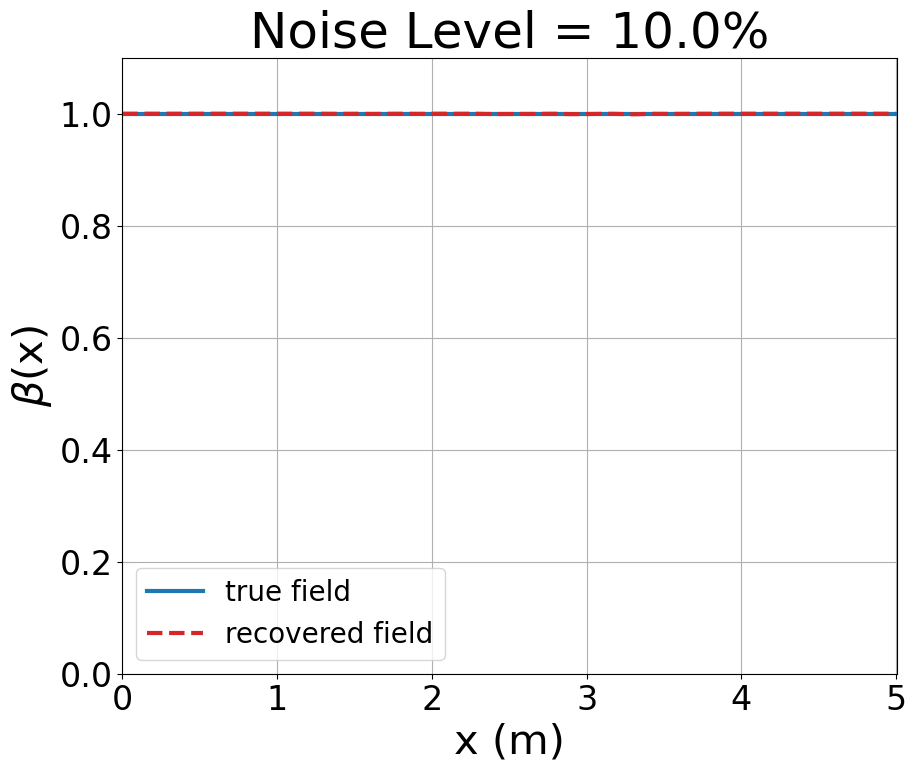

In [48]:
plt.figure(figsize=(10, 8))
plt.plot(x_space, damage, "C0", label='true field', linewidth = 3)
if model_error:
    ii = 0
    for error in model_error:
        if reduced_model_points:
            if field_smoothing:
                plt.plot(x_space, smooth_pred_plus_list[ii], f"C{1+ii}", label=f'$\delta={error}$', linestyle='dashed', linewidth = 3)
                plt.plot(x_space, smooth_pred_minus_list[ii], f"C{1+ii}", linestyle='dashed', linewidth = 3)
                plt.fill_between(x_space, smooth_pred_minus_list[ii], smooth_pred_plus_list[ii], alpha=0.2, color=f"C{3+ii}")
            else:
                plt.plot(reduced_x_space, pred_plus_list[ii], f"C{1+ii}", label=f'$\delta={error}$', linestyle='dashed', linewidth = 3)
                plt.plot(reduced_x_space, pred_minus_list[ii], f"C{1+ii}", linestyle='dashed', linewidth = 3)
                plt.fill_between(reduced_x_space, pred_minus_list[ii], pred_plus_list[ii], alpha=0.2, color=f"C{3+ii}")
        else:
            plt.plot(x_space, pred_plus_list[ii], f"C{1+ii}", label=f'$\delta={error}$', linestyle='dashed', linewidth = 3)
            plt.plot(x_space, pred_minus_list[ii], f"C{1+ii}", linestyle='dashed', linewidth = 3)
            plt.fill_between(x_space, pred_minus_list[ii], pred_plus_list[ii], alpha=0.2, color=f"C{3+ii}")
        ii += 1
else:
    if reduced_model_points:
        if field_smoothing:
            plt.plot(x_space, lower_pct, "C3", linestyle='dashed', linewidth = 3)
            plt.plot(x_space, upper_pct, "C3", linestyle='dashed', linewidth = 3)
            plt.fill_between(x_space, lower_pct, upper_pct, alpha=0.2, color="C3")
            plt.plot(
                reduced_x_space,
                pred,
                "C3",
                label='recovered field',
                linestyle='None',
                marker='o',
                markerfacecolor='C3',
                markeredgecolor='C3',
                markeredgewidth=3,
                markersize=10
            )
        else:
            plt.plot(reduced_x_space, pred, "C3", label='recovered field', linestyle='dashed', linewidth = 3)
    else:
        plt.plot(x_space, pred, "C3", label='recovered field', linestyle='dashed', linewidth = 3)
plt.title(f'Noise Level = {noise_level*100}%', size=36)
plt.legend(fontsize=20)
plt.grid(0.2)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.ylim([0, 1.1])
plt.xlim([x_space[0], x_space[-1]+0.01])
plt.xlabel("x (m)", size = 30)
plt.ylabel(r'$\beta$(x)', size = 30)
plt.savefig("all_flat_noisy.pdf", format="pdf", bbox_inches="tight")
plt.show()